**Import the required libraries**

In [ ]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
import torch

# Check if GPU is available
gpu_available = torch.cuda.is_available()

if gpu_available:
    print("GPU is available!")
    print(f"Number of GPUs detected: {torch.cuda.device_count()}")
else:
    print("No GPU detected. Please enable GPU in Runtime settings.")

device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")


GPU is available!
Number of GPUs detected: 1
GPU detected: Tesla T4


In [ ]:
# mount google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/SkinCancer/Dataset.zip" > /dev/null

replace Dataset/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Defining the path for train and test images**

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Dataset/Test")
data_dir_test = pathlib.Path("/content/Dataset/Train")

# Count the number of image in Train and Test directory

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118
2239


**Data Visualization**

Found 118 files belonging to 9 classes.


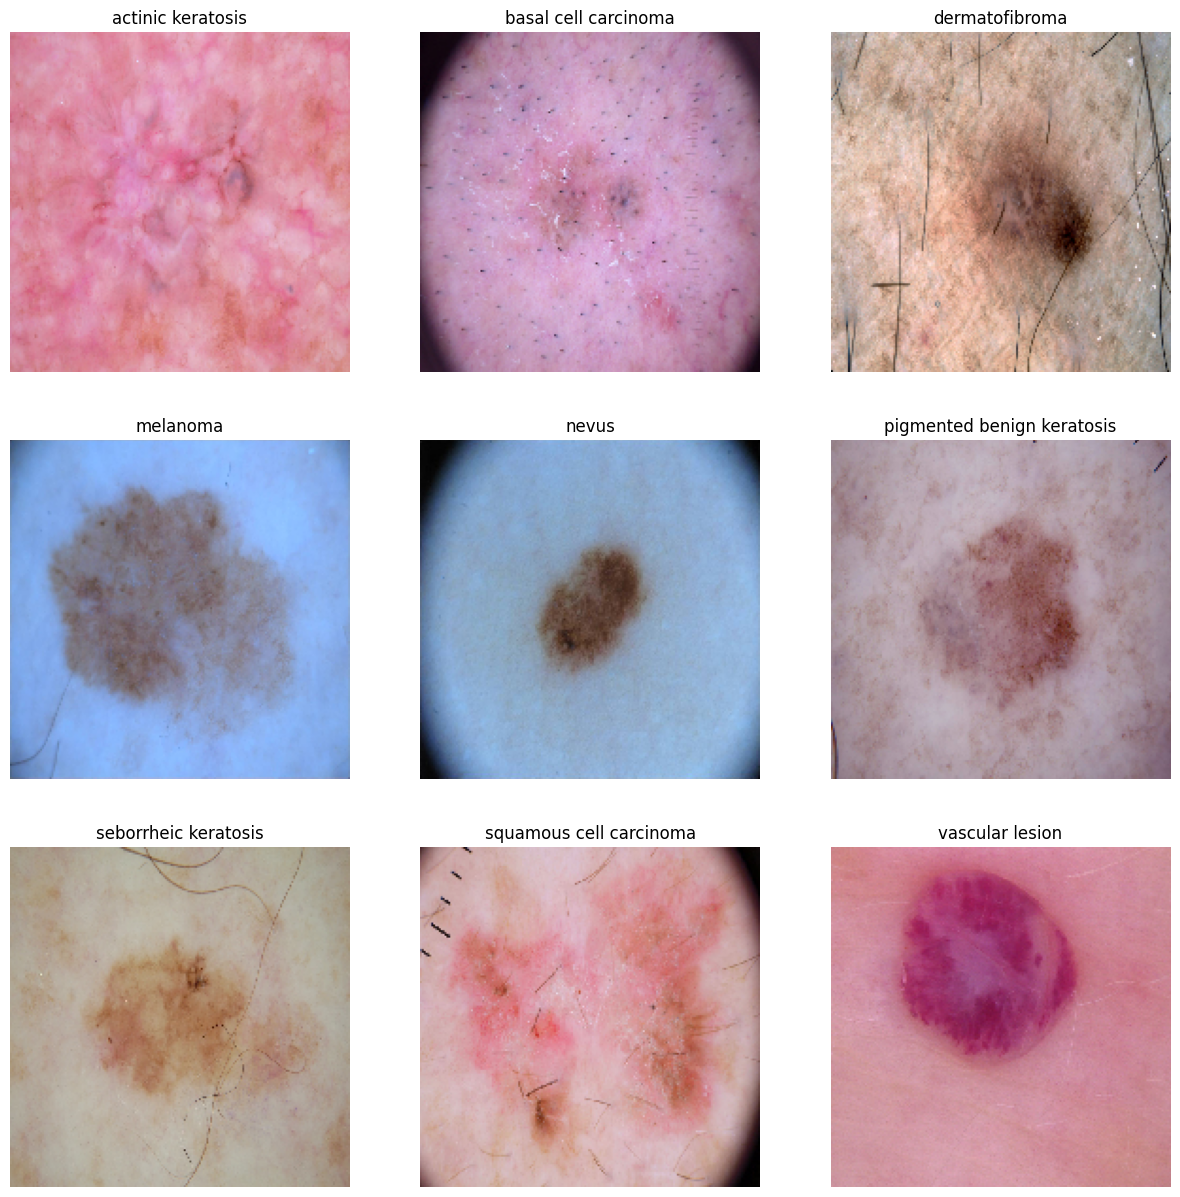

In [ ]:
#Visualize one instance of all the class present in the dataset.

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)
#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [ ]:
import pathlib
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

def count_images_in_directory(path):
    """Counts the number of images in a single directory."""
    if path.is_dir():
        return len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
    return 0

def class_distribution_count(directory):
    """Counts the number of images in each class directory using threads."""
    # Get the list of subdirectories (classes)
    sub_directories = [path for path in pathlib.Path(directory).iterdir() if path.is_dir()]

    # Use ThreadPoolExecutor to count images in each class concurrently
    with ThreadPoolExecutor() as executor:
        counts = list(executor.map(count_images_in_directory, sub_directories))

    # Extract class names
    class_names = [sub_dir.name for sub_dir in sub_directories]

    # Return a DataFrame with class names and image counts
    return pd.DataFrame(list(zip(class_names, counts)), columns=['Class', 'No. of Image'])

# Call the function and display the DataFrame
df = class_distribution_count(data_dir_train)
df


,Class,No. of Image
0,vascular lesion,3
1,dermatofibroma,16
2,seborrheic keratosis,3
3,nevus,16
4,squamous cell carcinoma,16
5,basal cell carcinoma,16
6,actinic keratosis,16
7,pigmented benign keratosis,16
8,melanoma,16


<Axes: xlabel='No. of Image', ylabel='Class'>

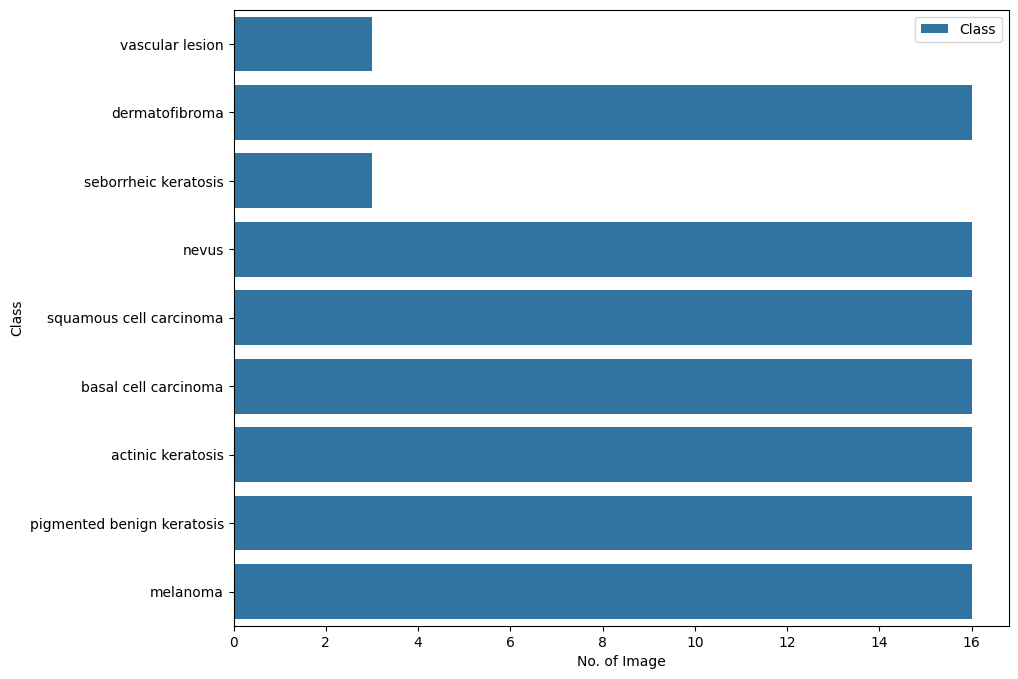

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")


In [ ]:
#install Augmentor
!pip install Augmentor

In [ ]:
path_to_training_dataset="/content/Dataset/Train/"
import Augmentor
import datetime

start = datetime.datetime.now()

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

end = datetime.datetime.now()

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor

# Path to training dataset
path_to_training_dataset = "/content/Dataset/Train/"

start1 = datetime.datetime.now()

# Augmentation parameters using ImageDataGenerator (runs on GPU)
datagen = ImageDataGenerator(
    rotation_range=10,  # Random rotation in degrees
    horizontal_flip=True,  # Random horizontal flipping
    fill_mode="nearest"  # Fill pixels after rotation
)

# Function to apply augmentation and save images for each class
def augment_class_with_tf(class_name):
    class_path = f"{path_to_training_dataset}/{class_name}"

    # Flow from directory for a specific class
    generator = datagen.flow_from_directory(
        directory=path_to_training_dataset,
        classes=[class_name],
        target_size=(180, 180),  # Image size to resize to
        batch_size=32,
        save_to_dir=class_path,  # Save augmented images
        save_format="jpeg"
    )

    # Generate 500 augmented samples
    for _ in range(500 // 32 + 1):
        next(generator)

# Use ThreadPoolExecutor for concurrent GPU image augmentation
with ThreadPoolExecutor() as executor:
    executor.map(augment_class_with_tf, class_names)

end1 = datetime.datetime.now()

print("\nWithout threading time spend : ", end-start)
print("With threading time spend : ", end1-start1)



# Calculate the time difference in seconds
time_diff1=(end-start).total_seconds()
time_diff2=(end1-start1).total_seconds()

# Calculate the percentage faster
percentage_faster=((time_diff1-time_diff2)/time_diff1)*100
print(f"Percentage Faster:{percentage_faster:.2f}%")


Initialised with 1650 image(s) found.
Output directory set to /content/Dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7CB7B4670460>: 100%|██████████| 500/500 [00:05<00:00, 99.25 Samples/s] 


Initialised with 1912 image(s) found.
Output directory set to /content/Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB8B41807F0>: 100%|██████████| 500/500 [00:08<00:00, 57.44 Samples/s]


Initialised with 1631 image(s) found.
Output directory set to /content/Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7CB8102B4D30>: 100%|██████████| 500/500 [00:04<00:00, 106.08 Samples/s]


Initialised with 1974 image(s) found.
Output directory set to /content/Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7CB7F7F2C0A0>: 100%|██████████| 500/500 [00:26<00:00, 18.85 Samples/s]


Initialised with 1893 image(s) found.
Output directory set to /content/Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7CB8153FB370>: 100%|██████████| 500/500 [00:14<00:00, 34.55 Samples/s]


Initialised with 1998 image(s) found.
Output directory set to /content/Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7CB939656E90>: 100%|██████████| 500/500 [00:06<00:00, 79.97 Samples/s]


Initialised with 1613 image(s) found.
Output directory set to /content/Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7CB8B27CFC70>: 100%|██████████| 500/500 [00:04<00:00, 112.00 Samples/s]


Initialised with 1717 image(s) found.
Output directory set to /content/Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=180x180 at 0x7CB8101B31F0>: 100%|██████████| 500/500 [00:03<00:00, 141.33 Samples/s]


Initialised with 1675 image(s) found.
Output directory set to /content/Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB7F7FC6980>: 100%|██████████| 500/500 [00:05<00:00, 91.76 Samples/s] 


Found 3150 images belonging to 1 classes.
Found 3393 images belonging to 1 classes.
Found 3412 images belonging to 1 classes.
Found 3131 images belonging to 1 classes.
Found 3498 images belonging to 1 classes.
Found 3474 images belonging to 1 classes.
Found 3113 images belonging to 1 classes.
Found 3217 images belonging to 1 classes.
Found 3175 images belonging to 1 classes.

Without threading time spend :  0:01:31.515926
With threading time spend :  0:00:37.882473
Percentage Faster:58.61%


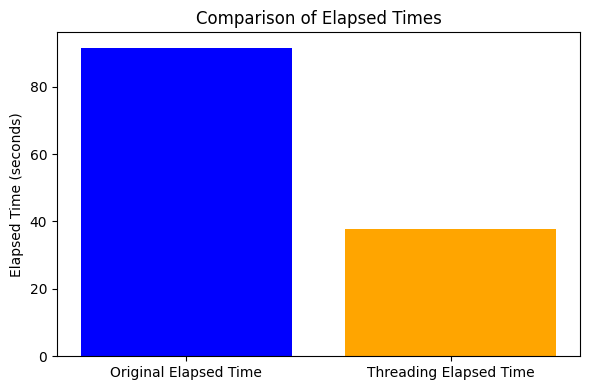

In [ ]:
import matplotlib.pyplot as plt

# Elapsed times (use your own computed values)
org_elapsed_time = (end - start).total_seconds()  # Without threading
threading_elapsed_time = (end1 - start1).total_seconds()  # With threading

# Labels for the bars
labels = ['Original Elapsed Time', 'Threading Elapsed Time']
values = [org_elapsed_time, threading_elapsed_time]

# Create the bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['blue', 'orange'])

# Adding labels and title
plt.ylabel('Elapsed Time (seconds)')
plt.title('Comparison of Elapsed Times')

# Show the chart
plt.tight_layout()
plt.show()


In [ ]:
# Count the total number of images in the training dataset after augmentation
augmented_image_count = len(list(pathlib.Path(path_to_training_dataset).glob('*/*.jpg')))
print(f"Total number of images after augmentation: {augmented_image_count}")

Total number of images after augmentation: 2239


**Model Building**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your dataset
path_to_training_dataset = "/content/Dataset/Train/"

# Enable GPU for TensorFlow
if tf.config.list_physical_devices('GPU'):
    print("GPU is available for data augmentation.")

    # Load and augment data for each class
    datagen = ImageDataGenerator(
        rotation_range=10,  # Rotation in degrees
        horizontal_flip=True,  # Randomly flip images horizontally
        fill_mode='nearest'  # Fill missing pixels after rotation
    )

    # Create augmented datasets for each class
    for class_name in class_names:
        class_path = f"{path_to_training_dataset}/{class_name}"
        # Use a generator to augment images and save them
        generator = datagen.flow_from_directory(
            directory=path_to_training_dataset,
            classes=[class_name],
            target_size=(128, 128),  # Resize images to desired size
            batch_size=32,
            save_to_dir=class_path,  # Save augmented images to the same class folder
            save_format="jpeg"
        )

        # Generate 500 augmented samples per class
        for _ in range(500 // 32 + 1):  # Adjust to match your batch size
            next(generator)
else:
    print("GPU not detected. Ensure CUDA and drivers are installed.")





GPU is available for data augmentation.
Found 3662 images belonging to 1 classes.
Found 3924 images belonging to 1 classes.
Found 3643 images belonging to 1 classes.
Found 3986 images belonging to 1 classes.
Found 3905 images belonging to 1 classes.
Found 4010 images belonging to 1 classes.
Found 3625 images belonging to 1 classes.
Found 3729 images belonging to 1 classes.
Found 3687 images belonging to 1 classes.


In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 118 files belonging to 9 classes.
Using 95 files for training.


In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**CNN Model Architecture**

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

# Rescaling Layer - Changed to use tf.keras.layers.experimental.preprocessing
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

** Vizualizing the model**

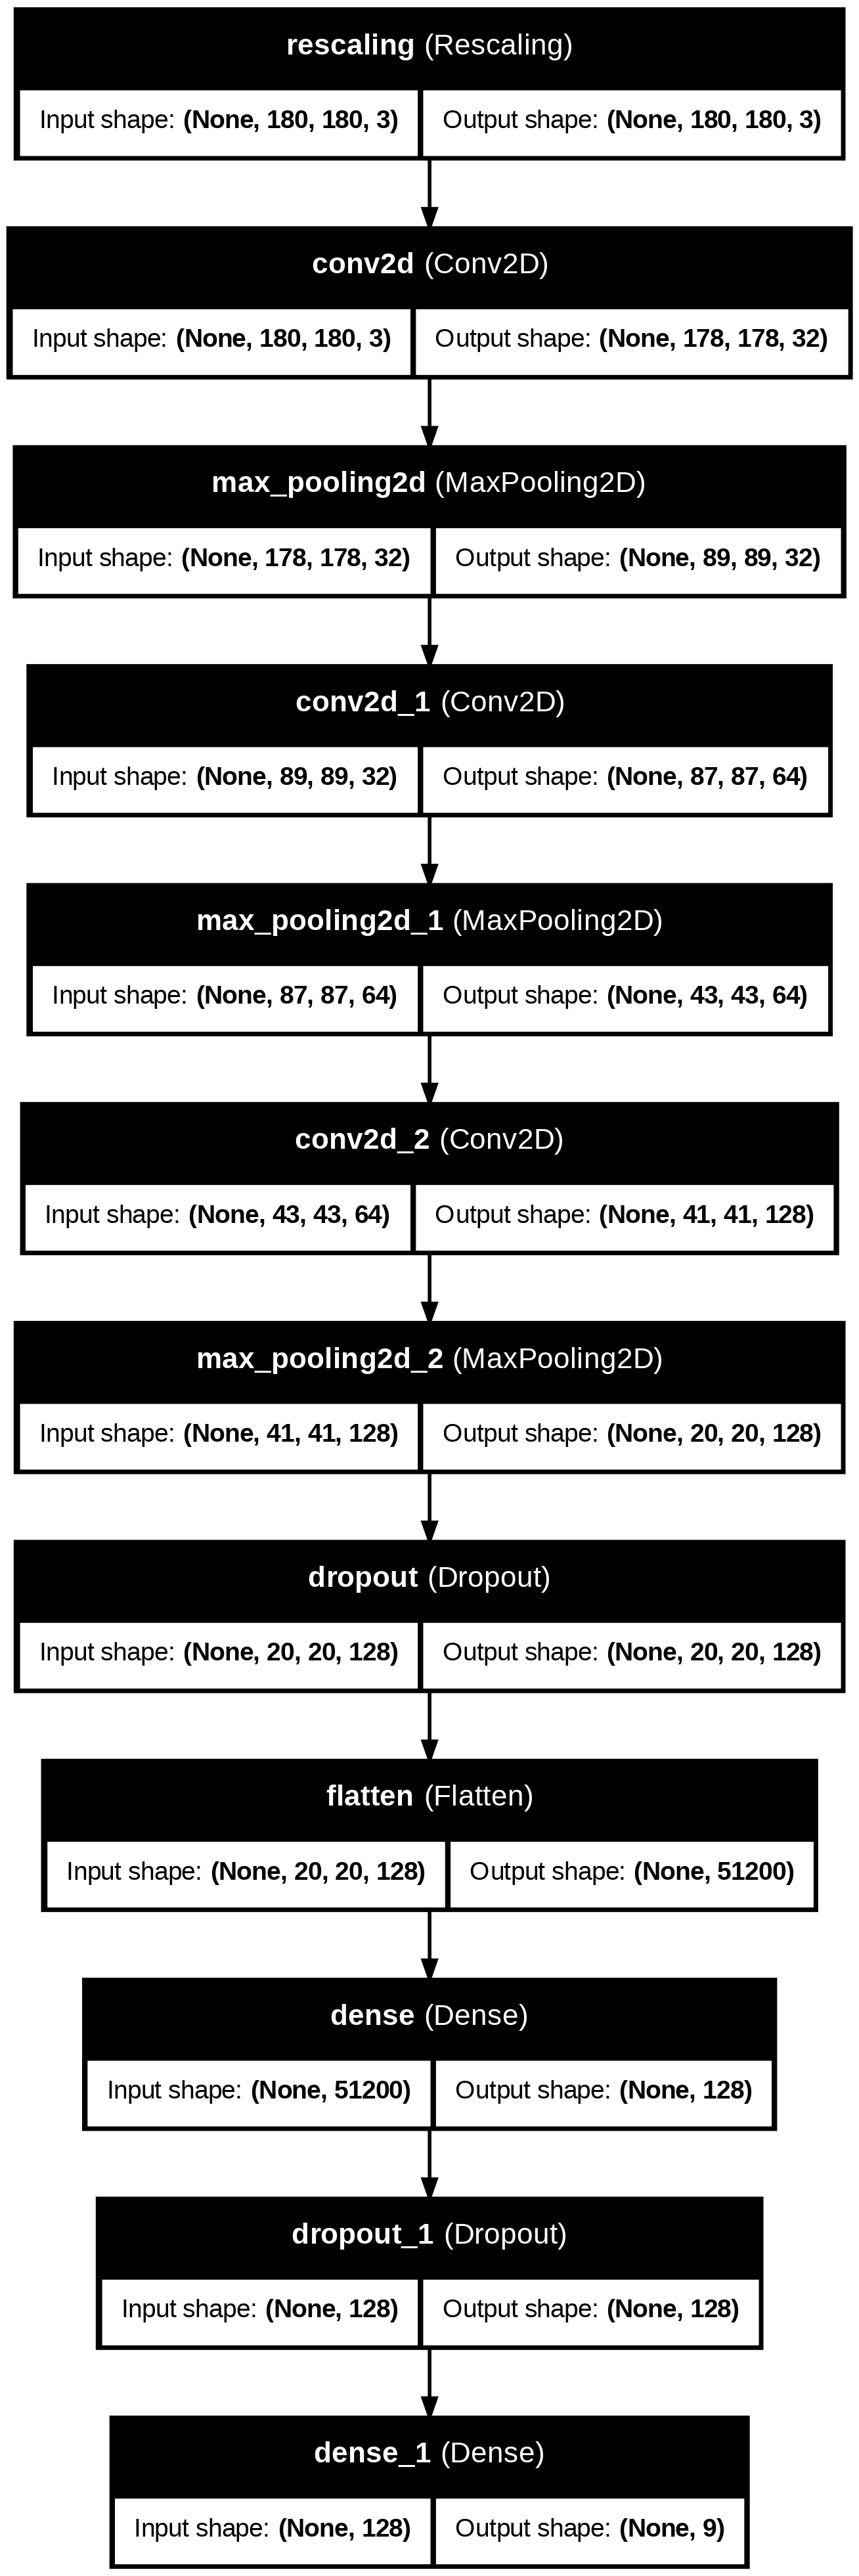

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available for training.")
else:
    print("No GPU detected. Please check your runtime settings.")

# Compile the model
# Adam optimization: A stochastic gradient descent method based on adaptive estimation of first-order and second-order moments.
# categorical_crossentropy: A loss function for multi-class classification with two or more output labels.
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

# ModelCheckpoint callback: Save model or weights (in a checkpoint file) at intervals to continue training from the saved state.
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# EarlyStopping callback: Stop training when the monitored metric stops improving.
earlystop = EarlyStopping(monitor="val_accuracy", patience=36, mode="auto", verbose=1)

# Example of fitting the model (use your own data and parameters)
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[checkpoint, earlystop])


GPU is available for training.


In [ ]:
# Train the model
epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/50
2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0057    
Epoch 1: val_accuracy improved from -inf to 0.34783, saving model to model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.3478 - val_loss: 19.3677
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9808 - loss: 0.0524
Epoch 2: val_accuracy did not improve from 0.34783
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9830 - loss: 0.0477 - val_accuracy: 0.3478 - val_loss: 15.4504
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0020    
Epoch 3: val_accuracy improved from 0.34783 to 0.39130, saving model to model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.3913 - val_loss: 13.5803
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9808 - loss: 0.1171
Epoch 4: val_accuracy did not improve from 0.39130
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0

In [ ]:
import numpy as np

# Get accuracy and validation accuracy values from training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Calculate the average accuracies
avg_train_accuracy = np.mean(train_accuracy)
avg_val_accuracy = np.mean(val_accuracy)

print(f"Average Training Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")


Average Training Accuracy: 0.9892
Average Validation Accuracy: 0.3083


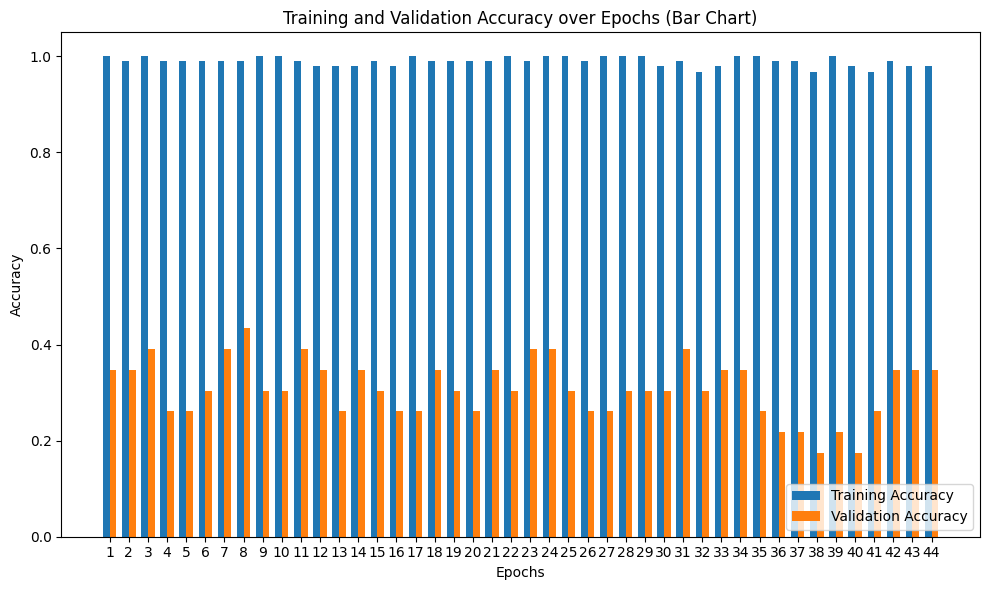

In [ ]:
import matplotlib.pyplot as plt

# After training your model, use this to create a bar chart
train_accuracy = history.history['accuracy']  # Training accuracy per epoch
val_accuracy = history.history['val_accuracy']  # Validation accuracy per epoch
epochs_range = range(1, len(train_accuracy) + 1)
width = 0.35  # Bar width for better distinction

plt.figure(figsize=(10, 6))

# Bar chart for training and validation accuracy
plt.bar([epoch - width / 2 for epoch in epochs_range], train_accuracy, width=width, label='Training Accuracy')
plt.bar([epoch + width / 2 for epoch in epochs_range], val_accuracy, width=width, label='Validation Accuracy')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (Bar Chart)')
plt.xticks(epochs_range)  # Show x-axis ticks for each epoch
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


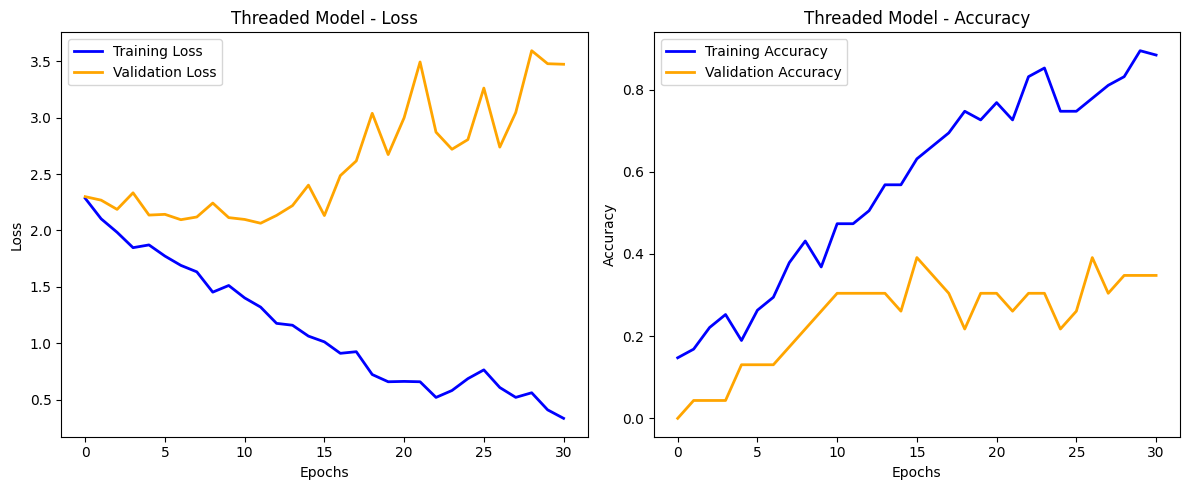

In [ ]:
import matplotlib.pyplot as plt

# Function to plot loss and accuracy graphs
def plot_loss_accuracy(history, title):
    plt.figure(figsize=(12, 5))  # Set figure size

    # Plot Loss
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()  # Adjust spacing
    plt.show()

# Example usage
plot_loss_accuracy(history, "Threaded Model")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Actual Class basal cell carcinoma
Predictive Class actinic keratosis


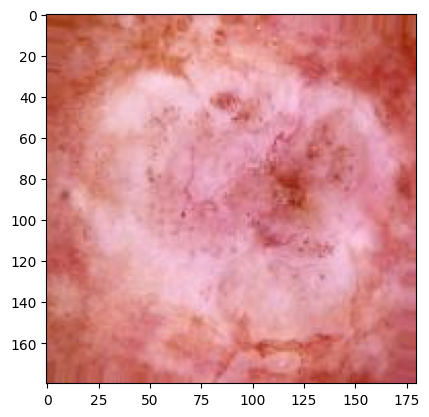

In [ ]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )